In [ ]:
import eddy_footprint as ef
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

from sublimpy import utils, extrautils

In [ ]:
start_date = '20221101'
end_date = '20230619'
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"

In [ ]:
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

In [ ]:
tidy_df = tidy_df[tidy_df.time.dt.month==12][tidy_df.time.dt.day > 0]

In [ ]:
import swifter

In [ ]:
tidy_df_streamwise = tidy_df.swifter.groupby('time').apply(extrautils.streamwise_coordinates_single_rotation_tidy_df)
tidy_df_streamwise = tidy_df_streamwise.reset_index(drop=True)

In [ ]:
footprint_inputs_table = tidy_df[tidy_df.variable.isin([
    'P_10m_c',
    
    'T_3m_c', 'u*_3m_c', 'spd_3m_c', 'v_v_3m_c', 'dir_3m_c', 'L_3m_c', 'v_v__3m_c',
    'T_5m_c', 'u*_5m_c', 'spd_5m_c', 'v_v_5m_c', 'dir_5m_c', 'L_5m_c', 'v_v__5m_c',
    'T_10m_c', 'u*_10m_c', 'spd_10m_c', 'v_v_10m_c', 'dir_10m_c', 'L_10m_c', 'v_v__10m_c',
    'T_15m_c', 'u*_15m_c', 'spd_15m_c', 'v_v_15m_c', 'dir_15m_c', 'L_15m_c', 'v_v__15m_c',
    'T_20m_c', 'u*_20m_c', 'spd_20m_c', 'v_v_20m_c', 'dir_20m_c', 'L_20m_c', 'v_v__20m_c',

    'u*_3m_d', 'spd_3m_d', 'v_v_3m_d', 'dir_3m_d', 'L_3m_d', 'v_v__3m_d',
    'u*_3m_ue', 'spd_3m_ue', 'v_v_3m_ue', 'dir_3m_ue', 'L_3m_ue', 'v_v__3m_ue',
    'u*_3m_uw', 'spd_3m_uw', 'v_v_3m_uw', 'dir_3m_uw', 'L_3m_uw', 'v_v__3m_uw',

    'u*_10m_d', 'spd_10m_d', 'v_v_10m_d', 'dir_10m_d', 'L_10m_d', 'v_v__10m_d',
    'u*_10m_ue', 'spd_10m_ue', 'v_v_10m_ue', 'dir_10m_ue', 'L_10m_ue', 'v_v__10m_ue',
    'u*_10m_uw', 'spd_10m_uw', 'v_v_10m_uw', 'dir_10m_uw', 'L_10m_uw', 'v_v__10m_uw',
])].pivot_table(
    index='time', 
    columns='variable', 
    values = 'value'
)

footprint_inputs_table.head(3)

# Using eddy_footprint library

In [ ]:
locs = [
    '3m_d', '3m_ue', '3m_uw', 
    '10m_d', '10m_ue', '10m_uw', 
    '3m_c', '5m_c', '10m_c', '15m_c', '20m_c',
    
]
foots_ls = []
for loc in locs:
    [height, tower] = loc.split('m_')
    foots_ls.append(
        ef.calc_footprint(
            air_pressure =          footprint_inputs_table.reset_index().dropna()['P_10m_c']*100,
            air_temperature =       footprint_inputs_table.reset_index().dropna()[f'T_{height}m_c'] + 273, 
            friction_velocity   =   footprint_inputs_table.reset_index().dropna()[f'u*_{height}m_{tower}'],
            wind_speed  =           footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'],
            cross_wind_variance =   footprint_inputs_table.reset_index().dropna()[f'v_v__{height}m_{tower}'],
            wind_direction  =       footprint_inputs_table.reset_index().dropna()[f'dir_{height}m_{tower}'],
            monin_obukhov_length =  footprint_inputs_table.reset_index().dropna()[f'L_{height}m_c'],
            time    =               footprint_inputs_table.reset_index().dropna().time,
            instrument_height   =   int(height),
            roughness_length    =   0.0001,
            resolution  =           2,
            workers =               -1,
            # method  =               'Hsieh',
            method="Kormann & Meixner",
            domain_length = 250
        )
    )

In [ ]:
new_foots_ls = []
for loc, foots in zip(locs,foots_ls):
    [height, tower] = loc.split('m_')
    foots = foots.expand_dims({"tower": [tower]})
    foots = foots.expand_dims({"height": [int(height)]})
    new_foots_ls.append(foots)

In [ ]:
c_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'c'],  dim='height')
d_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'd'],  dim='height')
ue_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'ue'],    dim='height')
uw_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'uw'],    dim='height')

In [ ]:
# e stability parameter is in the range of: -200 < ζ < 1 ;
# The friction velocity is larger than a specific threshold: u. ≥ 0.2 m s-1

valid_times = set(footprint_inputs_table[
    footprint_inputs_table['L_3m_c'] > -200
][
    footprint_inputs_table['L_3m_c'] < 1
].index)
valid_times = valid_times.union(set(
    footprint_inputs_table[footprint_inputs_table['u*_3m_c'] > 0.2]
))


In [ ]:
fig_facet = c_foots.sum(dim='time').plot(
    x='x',
    y='y',
    col='height',
    col_wrap=3,
    cmap='Reds',
    # vmax=2e-5,
    cbar_kwargs={'label': 'pixel weight'}
)
fig_facet.map(lambda: plt.plot(0, 0, marker=".", color="black", markersize=10))
plt.xlim(-100, 100)
plt.ylim(-100, 100)

In [ ]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df = instrument_loc_df[instrument_loc_df.index.get_level_values(0) == 3].droplevel(0)
instrument_loc_df

In [ ]:
def modify_xy(foots):
    xyz = instrument_loc_df.loc[foots['tower'].item()]
    foots['x'] = foots['x'] + xyz.x
    foots['y'] = foots['y'] + xyz.y
    return foots

[c_foots_adj, uw_foots_adj, ue_foots_adj, d_foots_adj] = [
    modify_xy(foots)
    for foots in
    [c_foots, uw_foots, ue_foots, d_foots]
]

In [ ]:
vmin = 0
vmax = 1.0
fig, axes = plt.subplots( 1,4, figsize=(20,5), sharex=True, sharey=True)
c_foots_adj.where(c_foots_adj).sel(height = 20).sum(dim='time').plot(   ax = axes[0], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
d_foots_adj.where(d_foots_adj).sel(height = 10).sum(dim='time').plot(   ax = axes[1], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
uw_foots_adj.where(uw_foots_adj).sel(height = 10).sum(dim='time').plot(  ax = axes[2], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
im = ue_foots_adj.where(ue_foots_adj).sel(height = 10).sum(dim='time').plot(  ax = axes[3], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)

for ax in axes:
    ax.set_xlim(instrument_loc_df.x.min()-60, instrument_loc_df.x.max()+60)
    ax.set_ylim(instrument_loc_df.y.min()-60, instrument_loc_df.y.max()+60)
    ax.scatter(instrument_loc_df.x, instrument_loc_df.y, color='black')
    ax.set_aspect('equal')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10, rotation=0)
    ax.set_xlabel('easting')
    ax.set_ylabel('northing')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [ ]:
xr.concat(
    [c_foots_adj,
    d_foots_adj,
    uw_foots_adj,
    ue_foots_adj],
    dim='tower'
)

# Using https://github.com/Open-ET/flux-data-footprint/blob/master/scripts/calc_footprint_FFP_climatology.py

In [ ]:
    # FFP Input
    #     All vectors need to be of equal length (one value for each time step)
    #     zm       = Measurement height above displacement height (i.e. z-d) [m]
    #                usually a scalar, but can also be a vector
    #     z0       = Roughness length [m] - enter [None] if not known
    #                usually a scalar, but can also be a vector
    #     umean    = Vector of mean wind speed at zm [ms-1] - enter [None] if not known
    #                Either z0 or umean is required. If both are given,
    #                z0 is selected to calculate the footprint
    #     h        = Vector of boundary layer height [m]
    #     ol       = Vector of Obukhov length [m]
    #     sigmav   = Vector of standard deviation of lateral velocity fluctuations [ms-1]
    #     ustar    = Vector of friction velocity [ms-1]
    #     wind_dir = Vector of wind direction in degrees (of 360) for rotation of the footprint

    #     Optional input:
    #     domain       = Domain size as an array of [xmin xmax ymin ymax] [m].
    #                    Footprint will be calculated for a measurement at [0 0 zm] m
    #                    Default is smallest area including the r% footprint or [-1000 1000 -1000 1000]m,
    #                    whichever smallest (80% footprint if r not given).
    #     dx, dy       = Cell size of domain [m]
    #                    Small dx, dy results in higher spatial resolution and higher computing time
    #                    Default is dx = dy = 2 m. If only dx is given, dx=dy.
    #     nx, ny       = Two integer scalars defining the number of grid elements in x and y
    #                    Large nx/ny result in higher spatial resolution and higher computing time
    #                    Default is nx = ny = 1000. If only nx is given, nx=ny.
    #                    If both dx/dy and nx/ny are given, dx/dy is given priority if the domain is also specified.
    #     rs           = Percentage of source area for which to provide contours, must be between 10% and 90%.
    #                    Can be either a single value (e.g., "80") or a list of values (e.g., "[10, 20, 30]")
    #                    Expressed either in percentages ("80") or as fractions of 1 ("0.8").
    #                    Default is [10:10:80]. Set to "None" for no output of percentages
    #     rslayer      = Calculate footprint even if zm within roughness sublayer: set rslayer = 1
    #                    Note that this only gives a rough estimate of the footprint as the model is not
    #                    valid within the roughness sublayer. Default is 0 (i.e. no footprint for within RS).
    #                    z0 is needed for estimation of the RS.
    #     smooth_data  = Apply convolution filter to smooth footprint climatology if smooth_data=1 (default)
    #     crop         = Crop output area to size of the 80% footprint or the largest r given if crop=1
    #     pulse        = Display progress of footprint calculations every pulse-th footprint (e.g., "100")
    #     verbosity    = Level of verbosity at run time: 0 = completely silent, 1 = notify only of fatal errors,
    #                    2 = all notifications
    #     fig          = Plot an example figure of the resulting footprint (on the screen): set fig = 1.
    #                    Default is 0 (i.e. no figure).

In [ ]:
from calc_footprint_FFP_climatology import ffp_climatology

locs = [
    '3m_d', '3m_ue', '3m_uw', 
    '10m_d', '10m_ue', '10m_uw', 
    '3m_c', '5m_c', '10m_c', '15m_c', '20m_c',
    
]
foots_ls = []
for loc in locs:
    [height, tower] = loc.split('m_')
    foots_ls.append(
        ffp_climatology(
            zm       = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                int(height),
            ),
            z0       = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                0.0001,
            ),
            umean    = footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values,
            h        = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                600
            ),
            ol       = footprint_inputs_table.reset_index().dropna()[f'L_{height}m_c'].values,
            sigmav   = np.sqrt(footprint_inputs_table.reset_index().dropna()[f'v_v__{height}m_{tower}']).values,
            ustar    = footprint_inputs_table.reset_index().dropna()[f'u*_{height}m_{tower}'].values,
            wind_dir = footprint_inputs_table.reset_index().dropna()[f'dir_{height}m_{tower}'].values,
            fig=True,
        
            crop=True,
            verbosity=1

        )
    )

# Using footprint.kljun.net/download_2.php

In [91]:

# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

In [72]:
import FFP_Python.calc_footprint_FFP_climatology as footprint_clim
from matplotlib.colors import LogNorm

src_3m = footprint_inputs_table.head(200)
results_3m = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_3m['spd_3m_c'].values),
    h        = list(np.full(len(src_3m), 600)),
    ol       = list(src_3m['L_3m_c'].values),
    sigmav   = list(src_3m['v_v__3m_c'].values),
    ustar    = list(src_3m['u*_3m_c'].values),
    wind_dir = list(src_3m['dir_3m_c'].values),
)

src_20m = footprint_inputs_table.head(200)
results_20m = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_20m['spd_20m_c'].values),
    h        = list(np.full(len(src_20m), 600)),
    ol       = list(src_20m['L_20m_c'].values),
    sigmav   = list(src_20m['v_v__20m_c'].values),
    ustar    = list(src_20m['u*_20m_c'].values),
    wind_dir = list(src_20m['dir_20m_c'].values),
)




Alert(0017):
 Only one value of zm passed. Using it for all footprints.
 Execution continues.

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  200

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  11  of  200

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0007):
 zm/ol (measurem

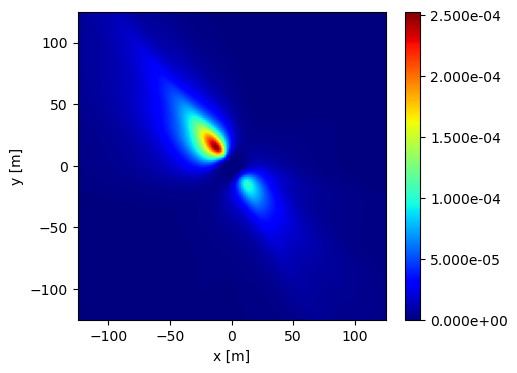

In [89]:
fig, ax = footprint_clim.plot_footprint(
    results_3m['x_2d'], 
    results_3m['y_2d'], 
    results_3m['fclim_2d'], 
    show_heatmap=True, 
    normalize=True, 
    colormap=None, 
    line_width=0.5, 
    iso_labels=None,
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

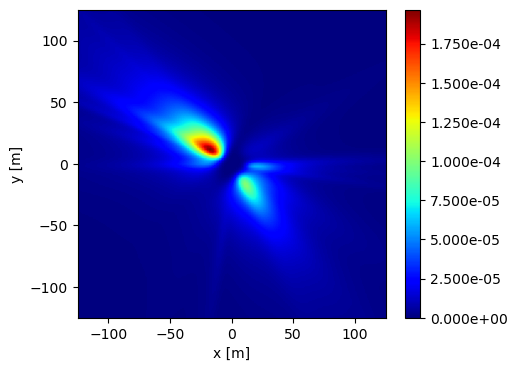

In [82]:
fig, ax = footprint_clim.plot_footprint(
    results_20m['x_2d'], 
    results_20m['y_2d'], 
    results_20m['fclim_2d'], 
    clevs=None, 
    show_heatmap=True, 
    normalize=True, 
    colormap=None, 
    line_width=0.5, 
    iso_labels=None,
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

In [97]:
import FFP_Python.calc_footprint_FFP_climatology as footprint_clim
from matplotlib.colors import LogNorm

ri_stable_times
ri_unstable_times
ri_neutral_times

src_3m = footprint_inputs_table.head(200)
src_3m_stable = src_3m[src_3m.index.isin(ri_stable_times)]
src_3m_unstable = src_3m[src_3m.index.isin(ri_unstable_times)]
src_3m_neutral = src_3m[src_3m.index.isin(ri_neutral_times)]

results_3m_stable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_3m_stable['spd_3m_c'].values),
    h        = list(np.full(len(src_3m_stable), 600)),
    ol       = list(src_3m_stable['L_3m_c'].values),
    sigmav   = list(src_3m_stable['v_v__3m_c'].values),
    ustar    = list(src_3m_stable['u*_3m_c'].values),
    wind_dir = list(src_3m_stable['dir_3m_c'].values),
)

results_3m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_3m_unstable['spd_3m_c'].values),
    h        = list(np.full(len(src_3m_unstable), 600)),
    ol       = list(src_3m_unstable['L_3m_c'].values),
    sigmav   = list(src_3m_unstable['v_v__3m_c'].values),
    ustar    = list(src_3m_unstable['u*_3m_c'].values),
    wind_dir = list(src_3m_unstable['dir_3m_c'].values),
)


results_3m_neutral = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_3m_neutral['spd_3m_c'].values),
    h        = list(np.full(len(src_3m_neutral), 600)),
    ol       = list(src_3m_neutral['L_3m_c'].values),
    sigmav   = list(src_3m_neutral['v_v__3m_c'].values),
    ustar    = list(src_3m_neutral['u*_3m_c'].values),
    wind_dir = list(src_3m_neutral['dir_3m_c'].values),
)




Alert(0017):
 Only one value of zm passed. Using it for all footprints.
 Execution continues.

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  41

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0009):
 ustar (friction velocity) must be >=0.1.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  3  of  41

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  5  of  41

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):

In [98]:
import FFP_Python.calc_footprint_FFP_climatology as footprint_clim
from matplotlib.colors import LogNorm

ri_stable_times
ri_unstable_times
ri_neutral_times

src_20m = footprint_inputs_table.head(200)
src_20m_stable = src_20m[src_20m.index.isin(ri_stable_times)]
src_20m_unstable = src_20m[src_20m.index.isin(ri_unstable_times)]
src_20m_neutral = src_20m[src_20m.index.isin(ri_neutral_times)]

results_20m_stable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_20m_stable['spd_20m_c'].values),
    h        = list(np.full(len(src_20m_stable), 600)),
    ol       = list(src_20m_stable['L_20m_c'].values),
    sigmav   = list(src_20m_stable['v_v__20m_c'].values),
    ustar    = list(src_20m_stable['u*_20m_c'].values),
    wind_dir = list(src_20m_stable['dir_20m_c'].values),
)

results_20m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_20m_unstable['spd_20m_c'].values),
    h        = list(np.full(len(src_20m_unstable), 600)),
    ol       = list(src_20m_unstable['L_20m_c'].values),
    sigmav   = list(src_20m_unstable['v_v__20m_c'].values),
    ustar    = list(src_20m_unstable['u*_20m_c'].values),
    wind_dir = list(src_20m_unstable['dir_20m_c'].values),
)


results_20m_neutral = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_20m_neutral['spd_20m_c'].values),
    h        = list(np.full(len(src_20m_neutral), 600)),
    ol       = list(src_20m_neutral['L_20m_c'].values),
    sigmav   = list(src_20m_neutral['v_v__20m_c'].values),
    ustar    = list(src_20m_neutral['u*_20m_c'].values),
    wind_dir = list(src_20m_neutral['dir_20m_c'].values),
)




Alert(0017):
 Only one value of zm passed. Using it for all footprints.
 Execution continues.

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  41
Calculating footprint  3  of  41
Calculating footprint  5  of  41
Calculating footprint  7  of  41
Calculating footprint  9  of  41

Error(0008):
 sigmav (standard deviation of crosswind) must be larger than zero.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  11  of  41
Calculating footprint  13  of  41
Calculating footprint  15  of  41
Calculating footprint  17  of  41
Calculating footprint  19  of  41

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  21  of  41
Calculating footprint  2

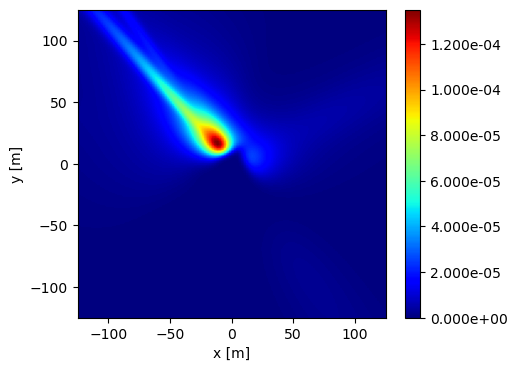

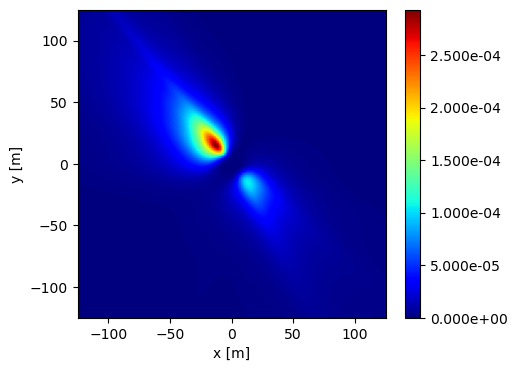

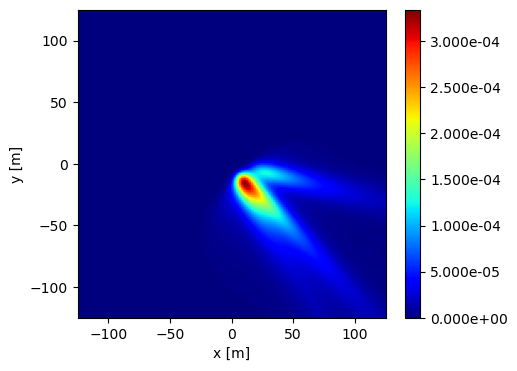

In [102]:
fig, ax = footprint_clim.plot_footprint(
    results_3m_stable['x_2d'], 
    results_3m_stable['y_2d'], 
    results_3m_stable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_3m_neutral['x_2d'], 
    results_3m_neutral['y_2d'], 
    results_3m_neutral['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_3m_unstable['x_2d'], 
    results_3m_unstable['y_2d'], 
    results_3m_unstable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

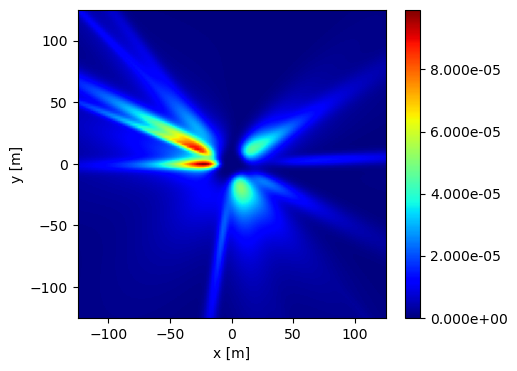

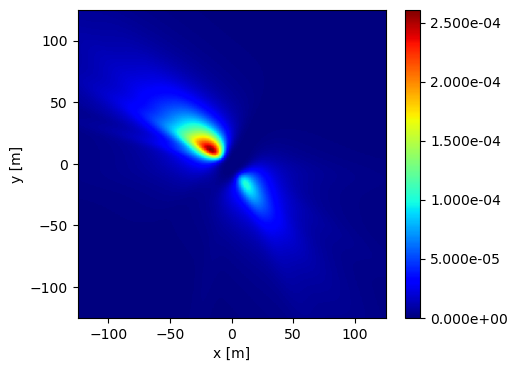

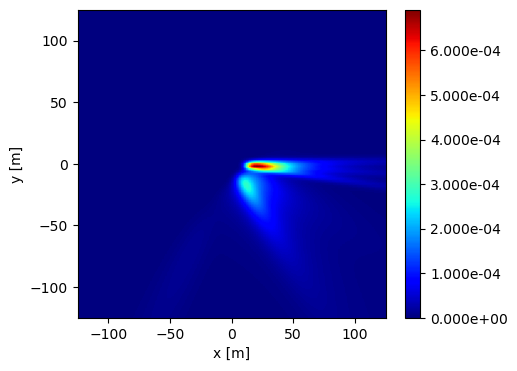

In [103]:
fig, ax = footprint_clim.plot_footprint(
    results_20m_stable['x_2d'], 
    results_20m_stable['y_2d'], 
    results_20m_stable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_20m_neutral['x_2d'], 
    results_20m_neutral['y_2d'], 
    results_20m_neutral['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_20m_unstable['x_2d'], 
    results_20m_unstable['y_2d'], 
    results_20m_unstable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.show()